## 1. Methode : Regressionsbaum

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, roc_auc_score)


# Setze den relativen Pfad zur Datei
dateipfad = os.path.join("/Users/danielambach/Projects/data_mining_dsba/data/processed/", "hotel_bookings_processed.csv")

df = pd.read_csv(dateipfad)
# df = df.drop('Unnamed: 0', axis=1)


# Entfernen von Spalten mit Dataleakage also spalten, die nicht für die Vorhersage verwendet werden können
notinuse_col =['reservation_status_date',
               'arrival_date_year',
               'arrival_date_month',
               'arrival_date_week_number', 
               'assigned_room_type',
                'reservation_status']

df.drop(notinuse_col, axis = 1, inplace = True)


categorical_cols = [col for col in df.columns if df[col].dtype == 'O']


# One-hot encoding for categorical variables
for var in categorical_cols:
    dummies = pd.get_dummies(df[var], prefix=var)
    df = pd.concat([df, dummies], axis=1)
    df.drop(var, axis=1, inplace=True)  


In [9]:
# --------------------------------------------------------------------
# 1) Feature-Matrix und Zielvariable definieren
# --------------------------------------------------------------------
X = df.drop('is_canceled', axis=1)  # Ersetze 'is_canceled' mit deinem Zielspaltennamen
y = df['is_canceled']               # Ersetze 'is_canceled' mit deinem Zielspaltennamen



In [10]:
# --------------------------------------------------------------------
# 2) Aufteilen in Trainings- und Testset
# --------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Stratifizierung empfohlen bei Klassifikation
)


In [11]:
# --------------------------------------------------------------------
# 3) Klassifikationsbaum + Hyperparameter-Tuning mit GridSearchCV
# --------------------------------------------------------------------
classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# scoring='accuracy' ist eine übliche Metrik,
# du kannst aber auch 'f1' oder 'roc_auc' verwenden
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

# GridSearchCV führt intern ein Fit durch, um das beste Modell zu finden.
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [12]:
# --------------------------------------------------------------------
# 4) Bestes Modell auswählen
# --------------------------------------------------------------------
best_classifier = grid_search.best_estimator_

# best_estimator_ ist bereits auf den Trainingsdaten gefittet;
# falls du möchtest, kannst du noch einmal explizit fitten:
# best_classifier.fit(X_train, y_train)

print("Beste Hyperparameter:", grid_search.best_params_)
print("Bester CV-Score (Accuracy):", grid_search.best_score_)

Beste Hyperparameter: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Bester CV-Score (Accuracy): 0.8394861380907747


In [13]:
# --------------------------------------------------------------------
# 5) Vorhersagen und Performance-Metriken
# --------------------------------------------------------------------
y_pred = best_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Diverse Metriken
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Ausführlicheres Bericht
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))



Confusion Matrix:
 [[13463  1570]
 [ 2297  6548]]
Accuracy:  0.8381
Precision: 0.8066
Recall:    0.7403
F1-Score:  0.7720

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87     15033
           1       0.81      0.74      0.77      8845

    accuracy                           0.84     23878
   macro avg       0.83      0.82      0.82     23878
weighted avg       0.84      0.84      0.84     23878



ROC-AUC: 0.9186


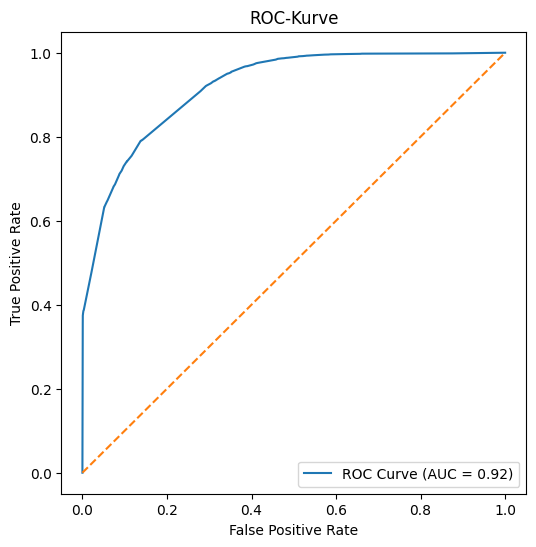

In [14]:
# --------------------------------------------------------------------
# 6) ROC-Kurve und AUC
# --------------------------------------------------------------------
# Da DecisionTreeClassifier eine Wahrscheinlichkeitsvorhersage liefern kann,
# nutzen wir predict_proba für die ROC-Kurve und den AUC-Wert.
y_proba = best_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_value = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC: {auc_value:.4f}")

# Plot der ROC-Kurve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_value:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # Diagonale
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Kurve")
plt.legend(loc="lower right")
plt.show()



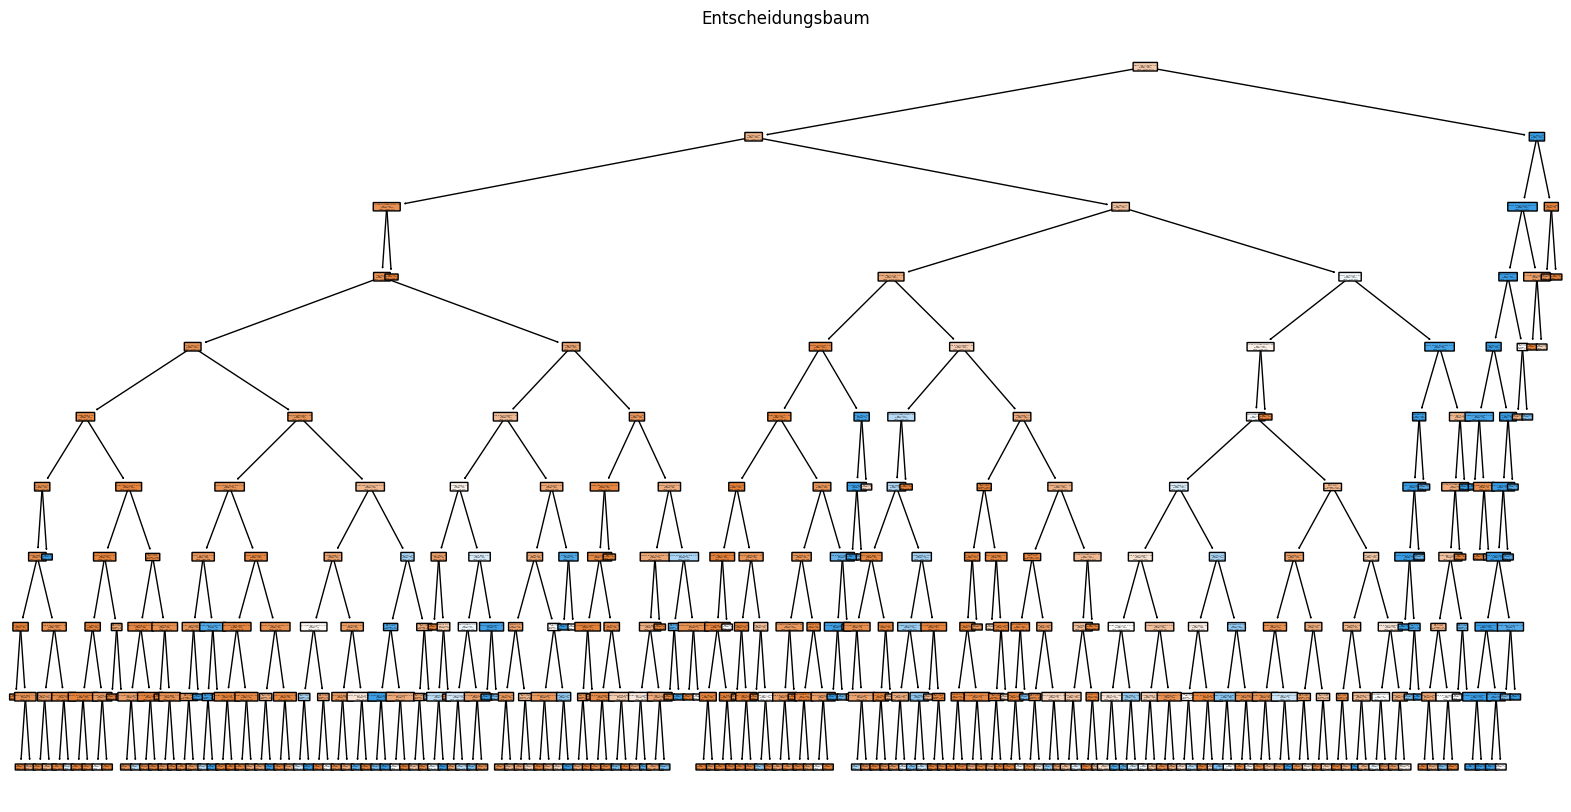

In [15]:
# --------------------------------------------------------------------
# 7) Entscheidungsbaum visualisieren (optional)
# --------------------------------------------------------------------
plt.figure(figsize=(20, 10))
plot_tree(best_classifier, filled=True, feature_names=X.columns, class_names=["0", "1"], rounded=True)
plt.title("Entscheidungsbaum")
plt.show()